# Loading Dataset

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/neurodegenerative-diseases/alzheimers_dataset/verymild_403.jpg
/kaggle/input/neurodegenerative-diseases/alzheimers_dataset/mild_309.jpg
/kaggle/input/neurodegenerative-diseases/alzheimers_dataset/mild_466.jpg
/kaggle/input/neurodegenerative-diseases/alzheimers_dataset/verymild_1231.jpg
/kaggle/input/neurodegenerative-diseases/alzheimers_dataset/mild_710.jpg
/kaggle/input/neurodegenerative-diseases/alzheimers_dataset/verymild_474.jpg
/kaggle/input/neurodegenerative-diseases/alzheimers_dataset/verymild_895.jpg
/kaggle/input/neurodegenerative-diseases/alzheimers_dataset/verymild_1379.jpg
/kaggle/input/neurodegenerative-diseases/alzheimers_dataset/verymild_1080.jpg
/kaggle/input/neurodegenerative-diseases/alzheimers_dataset/mild_96.jpg
/kaggle/input/neurodegenerative-diseases/alzheimers_dataset/verymild_1449.jpg
/kaggle/input/neurodegenerative-diseases/alzheimers_dataset/verymild_13.jpg
/kaggle/input/neurodegenerative-diseases/alzheimers_dataset/verymild_1340.jpg
/kaggle/inpu

# Visualizing Sample Images

Normal Images


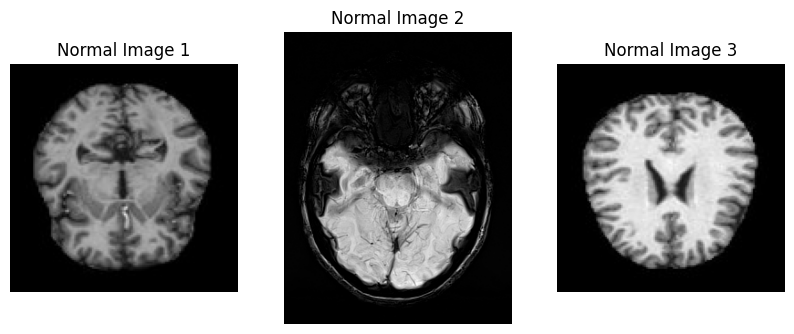

Alzheimer's Images


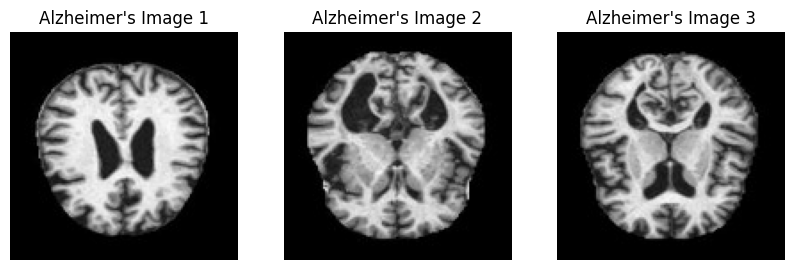

Parkinson's Images


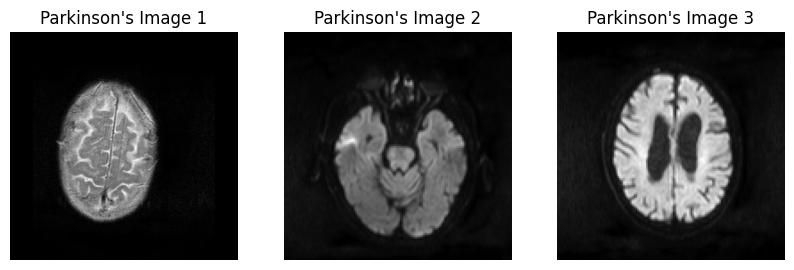

In [2]:
import matplotlib.pyplot as plt
import cv2
import os

# Function to visualize images from a directory
def visualize_images_from_directory(directory, title, num_images=3):
    plt.figure(figsize=(10, 10))
    image_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.png') or f.endswith('.jpg')]
    
    for i in range(min(num_images, len(image_files))):
        img = cv2.imread(image_files[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'{title} Image {i+1}')
    plt.show()

# Directories for each category (update these paths based on your dataset structure)
normal_dir = '/kaggle/input/neurodegenerative-diseases/normal'
alzheimers_dir = '/kaggle/input/neurodegenerative-diseases/alzheimers_dataset'
parkinsons_dir = '/kaggle/input/neurodegenerative-diseases/parkinsons_dataset'

# Visualize images from each category
print("Normal Images")
visualize_images_from_directory(normal_dir, "Normal")

print("Alzheimer's Images")
visualize_images_from_directory(alzheimers_dir, "Alzheimer's")

print("Parkinson's Images")
visualize_images_from_directory(parkinsons_dir, "Parkinson's")


# Data Preprocessing and Spiliting

In [3]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Define the dataset directory
data_dir = '/kaggle/input/neurodegenerative-diseases'

# Function to load image paths and labels
def load_image_paths_and_labels(data_dir):
    categories = ['normal', 'alzheimers_dataset', 'parkinsons_dataset']
    image_paths = []
    labels = []
    
    for idx, category in enumerate(categories):
        category_dir = os.path.join(data_dir, category)
        for img in os.listdir(category_dir):
            if img.endswith('.png') or img.endswith('.jpg') or img.endswith('.jpeg'):
                image_paths.append(os.path.join(category_dir, img))
                labels.append(idx)  # 0 = Normal, 1 = Alzheimer's, 2 = Parkinson's

    return np.array(image_paths), np.array(labels)

# Load image paths and labels
image_paths, labels = load_image_paths_and_labels(data_dir)

# Split the data into training (80%) and testing (20%) sets
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, stratify=labels, random_state=42)

# Helper function to load images
def path_to_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(150, 150))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0  # Normalize to [0, 1]
    return img

# Convert the image paths to actual image data
train_images = np.array([path_to_image(img_path) for img_path in train_paths])
test_images = np.array([path_to_image(img_path) for img_path in test_paths])


# Model Traning

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Build the CNN model with Dropout and Regularization
def build_qml_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        
        # Add dropout to prevent overfitting
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.3),  # Drop 30% of the units to prevent overfitting
        
        # L2 Regularization added in the Dense layer
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization
        
        # Output layer with 3 classes: Normal, Alzheimer's, Parkinson's
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    # Compile the model with a lower learning rate to avoid overfitting
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Build the model
model = build_qml_model()

# Train the model with early stopping
history = model.fit(
    train_images, train_labels, 
    epochs=35,  # Train for up to 35 epochs
    validation_data=(test_images, test_labels),
    callbacks=[early_stopping]  # Early stopping callback
)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/35
190/190 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.6503 - loss: 6.1971 - val_accuracy: 0.8248 - val_loss: 1.1772
Epoch 2/35
190/190 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.7943 - loss: 1.0037 - val_accuracy: 0.8327 - val_loss: 0.6866
Epoch 3/35
190/190 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.8315 - loss: 0.6394 - val_accuracy: 0.8281 - val_loss: 0.5517
Epoch 4/35
190/190 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.8397 - loss: 0.5132 - val_accuracy: 0.7905 - val_loss: 0.5190
Epoch 5/35
190/190 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.8485 - loss: 0.4452 - val_accuracy: 0.8458 - val_loss: 0.4087
Epoch 6/35
190/190 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.8594 - loss: 0.3958 - val_accuracy: 0.8860 - val_loss: 0.3538
Epoch 7/35
190/190 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.8690 - loss: 0.3806 - val_accuracy: 0.8874 - val_loss: 0.3607
Epoch 8/35
190/190 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.8776 - loss: 0.3480 - val_accu

# Visualizing Results

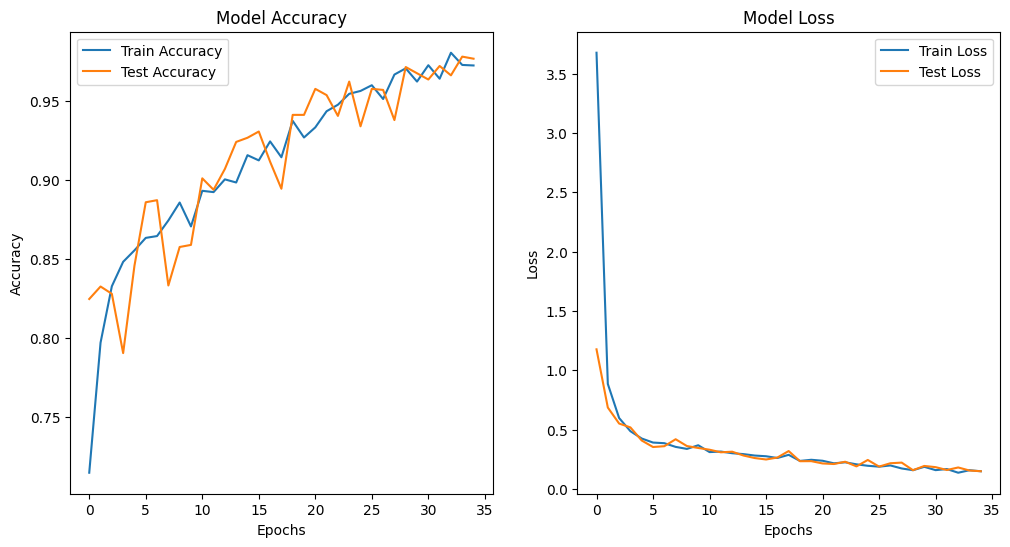

In [5]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 227ms/step


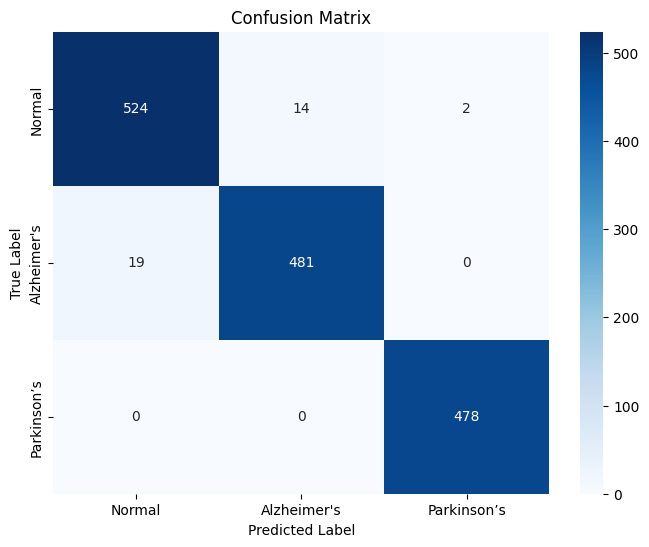

              precision    recall  f1-score   support

      Normal       0.97      0.97      0.97       540
 Alzheimer's       0.97      0.96      0.97       500
 Parkinson’s       1.00      1.00      1.00       478

    accuracy                           0.98      1518
   macro avg       0.98      0.98      0.98      1518
weighted avg       0.98      0.98      0.98      1518



In [6]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Make predictions on the test set
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate confusion matrix
cm = confusion_matrix(test_labels, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', "Alzheimer's", 'Parkinson’s'], yticklabels=['Normal', "Alzheimer's", 'Parkinson’s'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Generate classification report
print(classification_report(test_labels, y_pred_classes, target_names=['Normal', "Alzheimer's", 'Parkinson’s']))


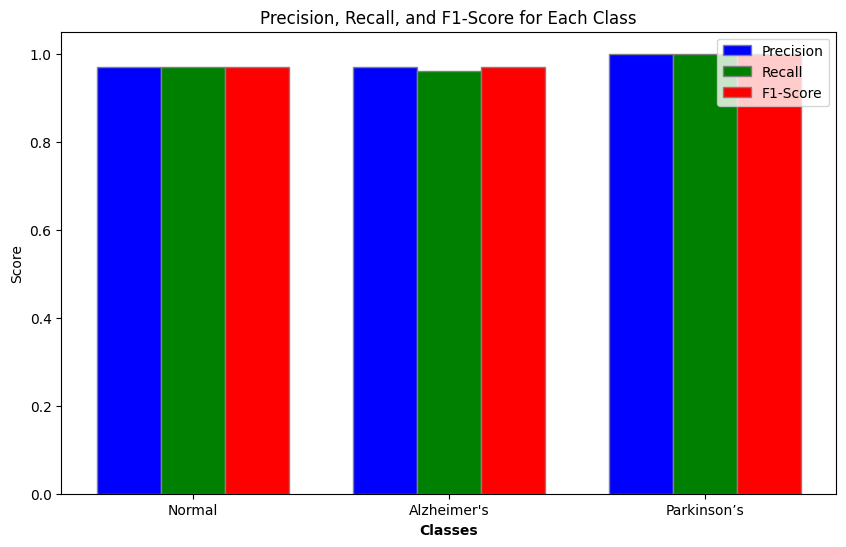

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Define the metrics for each class based on the performance provided
classes = ['Normal', "Alzheimer's", 'Parkinson’s']
precision = [0.97, 0.97, 1.00]
recall = [0.97, 0.96, 1.00]
f1_score = [0.97, 0.97, 1.00]

# Bar width
barWidth = 0.25

# Set position of bars on X axis
r1 = np.arange(len(classes))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Create the bar plot
plt.figure(figsize=(10, 6))

plt.bar(r1, precision, color='blue', width=barWidth, edgecolor='grey', label='Precision')
plt.bar(r2, recall, color='green', width=barWidth, edgecolor='grey', label='Recall')
plt.bar(r3, f1_score, color='red', width=barWidth, edgecolor='grey', label='F1-Score')

# Add labels and title
plt.xlabel('Classes', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(classes))], classes)
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score for Each Class')

# Add legend
plt.legend()

# Show the plot
plt.show()


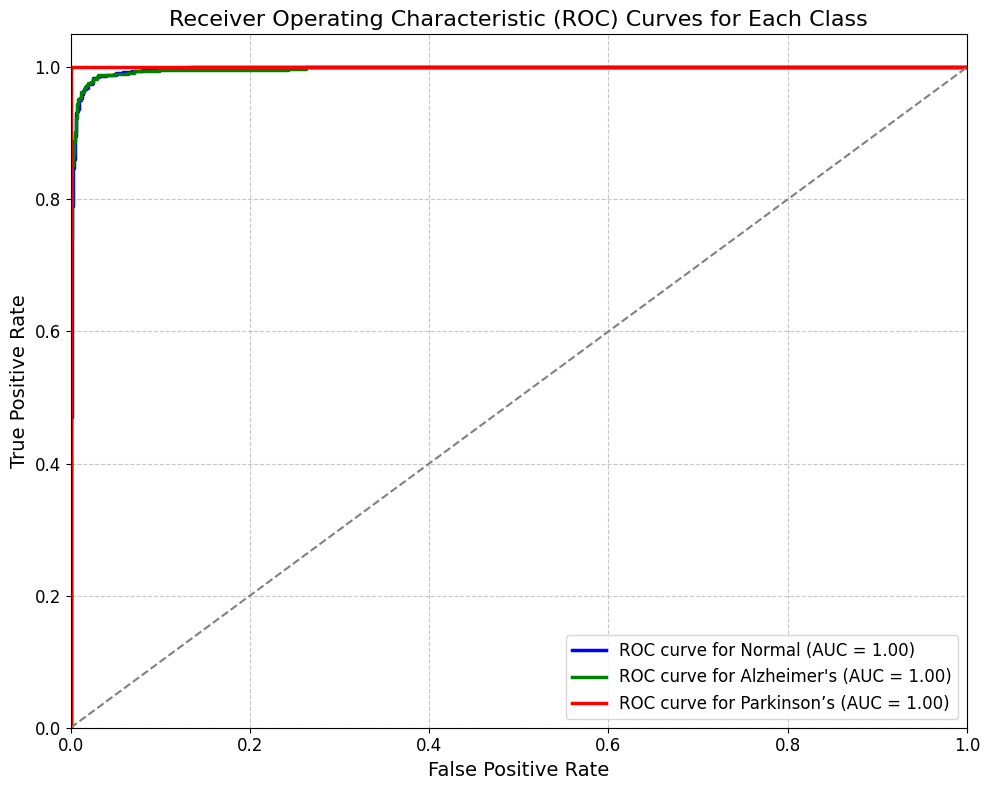

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Assuming you already have fpr, tpr, and roc_auc values calculated for each class

# Improved Plot
plt.figure(figsize=(10, 8))

colors = ['blue', 'green', 'red']
class_names = ['Normal', "Alzheimer's", 'Parkinson’s']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2.5,
             label=f'ROC curve for {class_names[i]} (AUC = {roc_auc[i]:0.2f})')

# Diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='grey', lw=1.5, linestyle='--')

# Axis labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curves for Each Class', fontsize=16)

# Add grid for clarity
plt.grid(True, linestyle='--', alpha=0.7)

# Customize ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Legend (positioned better)
plt.legend(loc="lower right", fontsize=12)

# Show the improved plot
plt.tight_layout()
plt.show()
